In [2]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime as dt
import decouple
import math
#from performance_stats import *
#from data_prep import *
#from loss_fcn import *
#from train_test import *
#from models import CNN_port




In [25]:
tickers = ['SPY', 'USO', 'UNG', 'GLD',
           'SLV', 'QQQ', 'IWM', 'MCHI',
           'EWJ', 'VWO', 'VGK', 'EQR',
           'VIXM']

In [3]:
def train_val_test(data, lookback=20, train_years=1, val_years=1, test_years=1):
    # drop NaNs
    data=data.dropna()
    
    # make train df
    year = data.index[-1].year
    x = data[dt(year+1,1,1,0,0,0):].first_valid_index().strftime("%Y-%m-%d")
    index_end_train = data.index.get_loc(x) + lookback
    x = data[dt(year+1+train_years,1,1,0,0,0):].first_valid_index().strftime("%Y-%m-%d")
    index_start_train = data.index.get_loc(x) + lookback
    
    df_train = data.iloc[index_start_train:index_end_train, :]
    
    # make validation df
    index_end_val = data.index.get_loc(df_train.index[0].strftime("%Y-%m-%d"))
    x = data[dt(year+1+train_years+val_years,1,1,0,0,0):].first_valid_index().strftime("%Y-%m-%d")
    index_start_val = data.index.get_loc(x) + lookback
    
    df_val = data.iloc[index_start_val:index_end_val, :]
    
    # make test df
    index_end_test = data.index.get_loc(df_val.index[0].strftime("%Y-%m-%d"))
    x = data[dt(year+1+train_years+val_years+test_years,1,1,0,0,0):].first_valid_index().strftime("%Y-%m-%d")
    index_start_test = data.index.get_loc(x) 
    
    df_test = data.iloc[index_start_test:index_end_test, :]
    
    return df_val.sort_index(), df_train.sort_index(), df_test.sort_index()


def get_targets(dataframe):
    targets = [dataframe[col] for col in dataframe.columns if 'return_next' in col]
    targets = pd.DataFrame(targets).transpose()
    return targets

def get_features(dataframe):
    features = [dataframe[col] for col in dataframe.columns if 'return_next' not in col]
    features = pd.DataFrame(features).transpose()
    return features

def get_attn_targs(dataframe):
    targs = [dataframe[col] for col in dataframe.columns if ('return_' in col) & ('return_next' not in col)]
    targs = pd.DataFrame(targs).transpose()
    return targs
    
    
def standardize(dataframe):
    df_standardized = pd.DataFrame()
    for col in dataframe.columns:
        col_mean = dataframe[col].mean()
        col_std = dataframe[col].std()
        df_standardized[col] = (dataframe[col] - col_mean) / col_std
    return df_standardized

def unstandardize(df_stand, df_orig):
    if len(df_stand.columns) == len(df_orig.columns):
        df_un = pd.DataFrame()
        for i, col in enumerate(df_stand.columns):
            col_og = df_orig.columns[i]
            df_un[col] = df_stand[col] * df_orig[col_og].std() + df_orig[col_og].mean()
        return df_un
    else:
        print("Value Error: Dataframes must have same column lengths")
        

        

In [4]:
class TS_Dataset(Dataset):
    def __init__(self, dataframe,lookback=20):
        self.lookback = lookback
        self.X = torch.tensor(standardize(get_features(dataframe)).values).float()
        self.y = torch.tensor(standardize(get_targets(dataframe)).values).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        if i >= self.lookback - 1:
            i_start = i - self.lookback + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.lookback - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [5]:
class TS_Dataset_attn(Dataset):
    def __init__(self, dataframe,lookback=20):
        self.lookback = lookback
        self.X = torch.tensor(standardize(get_features(dataframe)).values).float()
        self.y = torch.tensor(standardize(get_targets(dataframe)).values).float()
        self.tgt = torch.tensor(standardize(get_attn_targs(dataframe)).values).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        if i >= self.lookback - 1:
            i_start = i - self.lookback + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.lookback - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i], self.tgt[i]
    

In [6]:
def abs_softmax(x):
    """Returns weights with absolute values that sum to 1"""
    means = torch.mean(x, dim=1, keepdim=True)
    x_exp = torch.exp(x.abs()- means)
    x_exp_sum = torch.sum(x_exp,  dim=1, keepdims=True)
    
    return torch.sign(x)*x_exp/x_exp_sum


def sharpe_loss(weights, returns):
    """Calculate Sharpe ratio given by model weights"""
    portfolio_returns = weights.multiply(returns).sum(dim=1)
    sharpe = portfolio_returns.mean() / portfolio_returns.std()
    return -sharpe

# still uncertain if this is specified correctly or not due to 
# best way to do i

In [7]:
class FCN_port(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20 * 78, 32)
        self.fc2 = nn.Linear(32, 13)

        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.tanh(self.fc1(x))
        x = abs_softmax(self.fc2(x))
        return x

In [1414]:
class CNN_port(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 2)
        self.fc1 = nn.Linear(20 * 78 * 2, 13)
    
    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = abs_softmax(self.fc1(x))
        

In [8]:
class LSTM_port(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=13)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.
        out = torch.flatten(out, 1)
        
        out = abs_softmax(out)
        return out

In [9]:
class GRU_port(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.gru = nn.GRU(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=13)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, hn = self.gru(x, h0)
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.
        out = torch.flatten(out, 1)
        
        out = abs_softmax(out)
        return out

In [7]:
class PositionalEncoder(nn.Module):
    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=20, 
        d_model: int=512,
        batch_first: bool=True
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """
        super().__init__()
        self.d_model = d_model    
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first
        if  batch_first:
            self.x_dim = 1 
            position = torch.arange(max_seq_len).unsqueeze(1) # shape:  (20, 1)
            div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) #shape 256
            pe = torch.zeros(1, max_seq_len, d_model) # shape (20, 1, 512)
            pe[0, :, 0::2] = torch.sin(position * div_term)
            pe[0, :, 1::2] = torch.cos(position * div_term)
            self.register_buffer('pe', pe)
        
        else:
            self.x_dim = 0
            # copy pasted from PyTorch tutorial
            position = torch.arange(max_seq_len).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
            pe = torch.zeros(max_seq_len, 1, d_model)  # shape (20, 1, 512)
            pe[:, 0, 0::2] = torch.sin(position * div_term) #shape (20, 256)
            pe[:, 0, 1::2] = torch.cos(position * div_term) #shape (20, 256)
            self.register_buffer('pe', pe)

        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """

        x = x + self.pe[:x.size(self.x_dim)] # x shape is (32, 20, 512)

        return self.dropout(x)

In [8]:
class Transformer_port(nn.Module):
    def __init__(self,
        input_size: int,
        dec_seq_len: int,
        batch_first: True,
        out_seq_len: int=58,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        num_predicted_features: int=13
        ):
        
        super().__init__()
        self.dec_seq_len = dec_seq_len
        self.encoder_input_layer = nn.Linear(
            in_features=input_size,
            out_features=dim_val)

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features, # the number of features you want to predict
            out_features=dim_val) 

        self.linear = nn.Linear(
            in_features=dim_val,
            out_features=num_predicted_features)
        
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc)
        
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers,
            norm=None)
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first)
        
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers,
            norm=None)
        
        

        

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        
        src = self.encoder_input_layer(src) 
        src = self.positional_encoding_layer(src)
        src = self.encoder(src=src) # src shape: [batch_size, enc_seq_len, dim_val]

        decoder_output = self.decoder_input_layer(tgt) # outputs shpe (32, 512)
        decoder_output =  decoder_output.reshape(decoder_output.shape[0], 1, decoder_output.shape[1])
        
        decoder_output = self.decoder(
            tgt=decoder_output, #(32, 1, 512)
            memory=src, #(32, 20, 512)
            tgt_mask=tgt_mask, #(1, 1)
            memory_mask=src_mask) #(1, 20)
        
        decoder_output = self.linear(decoder_output)
        decoder_output = decoder_output.reshape(decoder_output.shape[0], decoder_output.shape[2])
        decoder_output = F.softmax(decoder_output)
        
        return decoder_output

In [1884]:
df_val, df_train, df_test = train_val_test(data, lookback, train_years=3) 
train_dataset = TS_Dataset(df_train, lookback=lookback)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

model = FCN_port()
predict(train_loader, model).shape

torch.Size([754, 13])

In [12]:
train_dataset = TS_Dataset_attn(df_train, lookback=lookback)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

model = Transformer_port(
    batch_first=True,
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads)
predict_attn(train_loader, model).shape

NameError: name 'df_train' is not defined

In [1846]:
Z = Transformer_port(input_size=78, dec_seq_len=20,  batch_first=True).encoder_input_layer(X)
Z1 = Transformer_port(input_size=78, dec_seq_len=20,  batch_first=True).positional_encoding_layer(Z) # (32, 20, 512)
Z2 = Transformer_port(input_size=78, dec_seq_len=20,  batch_first=True).encoder(src=Z1) # (32, 20, 512)
Transformer_port(input_size=78, dec_seq_len=20,  batch_first=True).decoder_input_layer(tgt).shape
tgt_mask = generate_square_subsequent_mask(dim1=1,dim2=1)
src_mask = generate_square_subsequent_mask(dim1=1,dim2=20)
tgt_mask.shape
src_mask.shape

torch.Size([1, 20])

In [11]:
def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)


In [10]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def train_model_attn(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y, trg in data_loader:
        enc_seq_len = X.shape[1]

        # Output length
        output_sequence_length = 1
        
        tgt_mask = generate_square_subsequent_mask(
        dim1=output_sequence_length,
        dim2=output_sequence_length)
        
        src_mask = generate_square_subsequent_mask(
        dim1=output_sequence_length,
        dim2=enc_seq_len)
        
        output = model(
            src=X,
            tgt=trg,
            src_mask=src_mask,
            tgt_mask=tgt_mask)
        
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss




def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()
    

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model_attn(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y, trg in data_loader:
            enc_seq_len = X.shape[1]

            # Output length
            output_sequence_length = 1
        
            tgt_mask = generate_square_subsequent_mask(
            dim1=output_sequence_length,
            dim2=output_sequence_length)
        
            src_mask = generate_square_subsequent_mask(
            dim1=output_sequence_length,
            dim2=enc_seq_len)
        
            output = model(
                src=X,
                tgt=trg,
                src_mask=src_mask,
                tgt_mask=tgt_mask)
            
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    return avg_loss


def early_stop(losses, tolerance=5):
    min_loss_idx = losses.index(min(losses))
    since_new_min = len(losses) - 1 - min_loss_idx
    if since_new_min >= tolerance:
        return True
    
def plot_losses(train_losses, val_losses):
    x = range(len(train_losses))
    plt.plot(x, train_losses, label='Train Loss')
    plt.plot(x, val_losses, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.show()

def plot_returns(p_return, bm_return, returns=True):
    x = range(len(p_return))
    if returns:
        plt.plot(x, p_return, label='Portfolio Return')
        plt.plot(x, bm_return, label='Benchmark Return')
    else:
        plt.plot(x, p_return, label='Portfolio Sharpe')
        plt.plot(x, bm_return, label='Benchmark Sharpe')
    plt.legend(loc='upper left')
    plt.show()


In [9]:
# define functions for obtaining/visualizing predictions
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

def predict_attn(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _, trg in data_loader:
            enc_seq_len = X.shape[1]
            # Output length
            output_sequence_length = 1
            
            tgt_mask = generate_square_subsequent_mask(
            dim1=output_sequence_length,
            dim2=output_sequence_length)
        
            src_mask = generate_square_subsequent_mask(
            dim1=output_sequence_length,
            dim2=enc_seq_len)
        
            y_star = model(
                src=X,
                tgt=trg,
                src_mask=src_mask,
                tgt_mask=tgt_mask)
            
            output = torch.cat((output, y_star), 0)
    
    return output


def get_pred_df_sharpe(df_train, df_test, model, batch_size,
                       lookback, tickers, num_assets=13, test_only=False):
    """Create dataframe with actual and un-normalized predicted return values """
    
    train_dataset = TS_Dataset(df_train, lookback=lookback)
    test_dataset = TS_Dataset(df_test, lookback=lookback)
    test_loader = DataLoader(test_dataset,
                        batch_size,
                        shuffle=False)
    
    train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    y_hat = '_port_weight'
    targets = get_targets(df_train)
    column_names = [col[(num_assets-1):] + y_hat for col in targets.columns]
    
    df_out_train = pd.DataFrame(predict(train_eval_loader, model).numpy(),
                         columns=column_names,
                         index=df_train.index)


    df_out_train = targets.join(df_out_train)
    
    df_out_test = pd.DataFrame(predict(test_loader, model).numpy(),
                              columns=column_names,
                              index=df_test.index)

    df_out_test = get_targets(df_test).join(df_out_test)
    
    df_out = pd.concat((df_out_train, df_out_test))

    df_out['return_next_portfolio'] = (df_out.iloc[:, num_assets:].values * df_out.iloc[:, :num_assets].values).sum(axis=1)
    df_out['return_portfolio'] = df_out['return_next_portfolio'].shift(1)
    
    # add benchmark column
    weight = 1 / num_assets
    weights = np.repeat(weight, num_assets)    
    df_out['return_next_benchmark'] = (df_out.iloc[:, :num_assets].values * weights).sum(axis=1)
    df_out['return_benchmark'] = df_out['return_next_benchmark'].shift(1)
    
    # add costs
    df_out = turnover_cost(df_out, tickers, bps=1)
    
    if test_only:
        year = df_test.index[0].year + 1
        date = str(year) + '-01-01'
        return df_out[df_out.index >= date]
    else:
        return df_out


def get_pred_df_sharpe_attn(df_train, df_test, model, batch_size,
                       lookback, tickers, num_assets=13, test_only=False):
    """Create dataframe with actual and un-normalized predicted return values """
    
    train_dataset = TS_Dataset_attn(df_train, lookback=lookback)
    test_dataset = TS_Dataset_attn(df_test, lookback=lookback)
    test_loader = DataLoader(test_dataset,
                        batch_size,
                        shuffle=False)
    
    train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    y_hat = '_port_weight'
    targets = get_targets(df_train)
    column_names = [col[(12-1):] + y_hat for col in targets.columns]
    
    df_out_train = pd.DataFrame(predict_attn(train_eval_loader, model).numpy(),
                         columns=column_names,
                         index=df_train.index)


    df_out_train = targets.join(df_out_train)
    
    df_out_test = pd.DataFrame(predict_attn(test_loader, model).numpy(),
                              columns=column_names,
                              index=df_test.index)

    df_out_test = get_targets(df_test).join(df_out_test)
    
    df_out = pd.concat((df_out_train, df_out_test))

    df_out['return_next_portfolio'] = (df_out.iloc[:, num_assets:].values * df_out.iloc[:, :num_assets].values).sum(axis=1)
    df_out['return_portfolio'] = df_out['return_next_portfolio'].shift(1)
    
    # add benchmark column
    weight = 1 / num_assets
    weights = np.repeat(weight, num_assets)    
    df_out['return_next_benchmark'] = (df_out.iloc[:, :num_assets].values * weights).sum(axis=1)
    df_out['return_benchmark'] = df_out['return_next_benchmark'].shift(1)
    
    # add costs
    df_out = turnover_cost(df_out, tickers, bps=1)
    
    if test_only:
        year = df_test.index[0].year + 1
        date = str(year) + '-01-01'
        return df_out[df_out.index >= date]
    else:
        return df_out


In [12]:
def total_return(return_col, start = True, stop = True, annualized=True):
    if start:
        start = return_col.index[0]
    if stop:
        stop = return_col.index[-1]
    if start > stop:
        print("Index Error: Start given is after Stop given")
    else:
        return_col = return_col[(return_col.index >= start) & (return_col.index <= stop)]
        return_col = return_col + 1
        ttl_return = 1
        for i in range(len(return_col)):
                ttl_return *= return_col[i]
        days  = (pd.to_datetime(stop) - pd.to_datetime(start)).days
        years = days / 365
        annualized_return = ttl_return ** (1 / years) - 1
        ttl_return -= 1
        if annualized == True:
            return annualized_return
        else:
            return ttl_return
        

def return_std(return_col, start = True, stop = True, annualized=True):
    if start:
        start = return_col.index[0]
    if stop:
        stop = return_col.index[-1]    
    if start > stop:
        print("Index Error: Start given is after Stop given")
    else:
        return_col = return_col[(return_col.index >= start) & (return_col.index <= stop)]
        if annualized:
            return return_col.std() * np.sqrt(250)
        else:
            return return_col.std()

def sharpe_ratio(return_col, start = True, stop = True):
    if start:
        start = return_col.index[0]
    if stop:
        stop = return_col.index[-1]
    ann_return = total_return(return_col, start, stop, annualized=True)
    ann_std = return_std(return_col, start, stop, annualized=True)
    
    return ann_return / ann_std
    
def turnover_cost(df_pred, tickers, bps=1):
    """Calculate costs from asset turnover"""
    df_pred = df_pred.sort_index(ascending=True)
    port_value = 1 # assume portfolio value = 1 after first time period
    costs = []
    cost_returns = []
    for i in range(df_pred.shape[0] - 1):
        cost_ticker = []
        for j, ticker in enumerate(tickers):
            asset_value_0 = port_value * df_pred[str(tickers[j]) + '_port_weight'][i]
            asset_value_1 = asset_value_0 * (1 + df_pred['return_next_' + str(tickers[j])][i])
            port_value_next = port_value * (1+df_pred['return_next_portfolio'][i])
            asset_value_next =  port_value_next * df_pred[str(tickers[j]) + '_port_weight'][i+1]        
            val_change = np.abs((asset_value_next - asset_value_1))
            cost = val_change * bps / 10000 * -1
            cost_ticker.append(cost)
        cost_sum = np.sum(cost_ticker)
        costs.append(cost_sum)
        cost_return = cost_sum / port_value
        cost_returns.append(cost_return)
        port_value *= (1 + df_pred['return_next_portfolio'][i] + cost_return)
    cost_returns.append(0)
    df_pred['cost_return_next'] = cost_returns
    df_pred['cost_return'] = df_pred['cost_return_next'].shift(1)
    df_pred['total_portfolio_return'] = df_pred['cost_return'] + df_pred['return_portfolio']
    return df_pred


In [13]:
# load data
config = decouple.AutoConfig(' ')
path = config('PATH_MY_MAIN_DATA')
data = pd.read_csv(path+'/_data_set_model', index_col='date', parse_dates=True)
pd.options.display.max_columns = None
data

return_A  norm_adjclose_A  norm_adjopen_A  norm_adjhigh_A  \
date                                                                    
2022-12-30 -0.008107       519.515107      519.896976      520.209414   
2022-12-29  0.019856       523.726689      518.596531      526.534410   
2022-12-28 -0.009859       513.327721      519.185806      524.697259   
2022-12-27  0.002140       518.388552      517.279329      519.289796   
2022-12-23  0.001474       517.279329      516.516738      520.814978   
...              ...              ...             ...             ...   
1999-11-05       NaN              NaN             NaN             NaN   
1999-11-04       NaN              NaN             NaN             NaN   
1999-11-03       NaN              NaN             NaN             NaN   
1999-11-02       NaN              NaN             NaN             NaN   
1999-11-01       NaN              NaN             NaN             NaN   

            norm_adjlow_A  norm_adj_range_pct_A  volume_dollars_MM_A  \
date                                                                   
2022-12-30     513.196914              0.013488             104.1521   
2022-12-29     516.551401              0.019250             128.5518   
2022-12-28     511.767876              0.024903             117.2586   
2022-12-27     510.589326              0.016820             130.6605   
2022-12-23     513.778343              0.013623             116.3176   
...                   ...                   ...                  ...   
1999-11-05            NaN                   NaN                  NaN   
1999-11-04            NaN                   NaN                  NaN   
1999-11-03            NaN                   NaN                  NaN   
1999-11-02            NaN                   NaN                  NaN   
1999-11-01            NaN                   NaN                  NaN   

            return_next_A  return_AAL  norm_adjclose_AAL  norm_adjopen_AAL  \
date                                                                         
2022-12-30            NaN    0.001572          69.920778         68.986302   
2022-12-29      -0.008107    0.029921          69.810839         68.106795   
2022-12-28       0.019856   -0.017045          67.722011         68.821395   
2022-12-27      -0.009859   -0.014366          68.876364         69.371086   
2022-12-23       0.002140    0.011802          69.865809         68.766425   
...                   ...         ...                ...               ...   
1999-11-05            NaN         NaN                NaN               NaN   
1999-11-04            NaN         NaN                NaN               NaN   
1999-11-03            NaN         NaN                NaN               NaN   
1999-11-02            NaN         NaN                NaN               NaN   
1999-11-01            NaN         NaN                NaN               NaN   

            norm_adjhigh_AAL  norm_adjlow_AAL  norm_adj_range_pct_AAL  \
date                                                                    
2022-12-30         70.497954        68.876364                0.023506   
2022-12-29         69.865809        67.584588                0.033495   
2022-12-28         69.700901        67.337227                0.034345   
2022-12-27         70.305562        68.134280                0.031300   
2022-12-23         69.865809        67.775881                0.030392   
...                      ...              ...                     ...   
1999-11-05               NaN              NaN                     NaN   
1999-11-04               NaN              NaN                     NaN   
1999-11-03               NaN              NaN                     NaN   
1999-11-02               NaN              NaN                     NaN   
1999-11-01               NaN              NaN                     NaN   

            volume_dollars_MM_AAL  return_next_AAL  return_AAP  \
date                                                             
2022-12-30               240

In [30]:
# load datasets
torch.manual_seed(55)

batch_size = 32
lookback = 20

df_val, df_train, df_test = train_val_test(data, lookback, train_years=3) 

train_dataset = TS_Dataset(df_train, lookback=lookback)
val_dataset = TS_Dataset(df_val, lookback=lookback)
test_dataset = TS_Dataset(df_test, lookback=lookback)

# Should I shuffle data for models with memory? RNN order matters
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)



Features shape: torch.Size([32, 20, 78])
Target shape: torch.Size([32, 13])


In [20]:
df_train.head()

return_SPY  norm_adjclose_SPY  norm_adjopen_SPY  norm_adjhigh_SPY  \
date                                                                            
2011-12-02   -0.000881         113.749268        114.897146        115.243332   
2011-12-05    0.010775         114.988248        115.553077        115.862822   
2011-12-06    0.000317         115.024688        114.979138        115.799051   
2011-12-07    0.003709         115.452865        114.642062        115.935703   
2011-12-08   -0.022428         112.920245        114.696723        114.951807   

            norm_adjlow_SPY  volume_dollars_MM_SPY  return_next_SPY  \
date                                                                  
2011-12-02       113.676387             27737.3858         0.010775   
2011-12-05       114.277657             28390.7587         0.000317   
2011-12-06       114.569181             22533.2387         0.003709   
2011-12-07       113.849480             29871.8279        -0.022428   
2011-12-08       112.646941             29995.9670         0.016660   

            return_USO  norm_adjclose_USO  norm_adjopen_USO  norm_adjhigh_USO  \
date                                                                            
2011-12-02    0.010761          57.380182         57.159659         57.468392   
2011-12-05   -0.000513          57.350779         58.027051         58.071156   
2011-12-06   -0.000256          57.336078         57.174360         57.571303   
2011-12-07   -0.004896          57.056748         57.438989         57.556601   
2011-12-08   -0.027263          55.542488         56.630403         56.821523   

            norm_adjlow_USO  volume_dollars_MM_USO  return_next_USO  \
date                                                                  
2011-12-02        56.645104               362.1398        -0.000513   
2011-12-05        56.909732               342.9994        -0.000256   
2011-12-06        56.953837               345.2310        -0.004896   
2011-12-07        56.586298               327.4119        -0.027263   
2011-12-08        55.454278               427.1586         0.018701   

            return_UNG  norm_adjclose_UNG  norm_adjopen_UNG  norm_adjhigh_UNG  \
date                                                                            
2011-12-02   -0.013906           7.790033          7.819578          7.854048   
2011-12-05   -0.036697           7.514280          7.583218          7.622612   
2011-12-06    0.006510           7.563522          7.484735          7.602915   
2011-12-07   -0.017219           7.435493          7.484735          7.494583   
2011-12-08    0.003958           7.465038          7.465038          7.681702   

            norm_adjlow_UNG  volume_dollars_MM_UNG  return_next_UNG  \
date                                                                  
2011-12-02         7.750640                78.3222        -0.036697   
2011-12-05         7.465038               120.9978         0.006510   
2011-12-06         7.445342                68.9375        -0.017219   
2011-12-07         7.396100                68.1785         0.003958   
2011-12-08         7.445342                86.6748        -0.031293   

            return_GLD  norm_adjclose_GLD  norm_adjopen_GLD  norm_adjhigh_GLD  \
date                                                                            
2011-12-02    0.001119         382.649842        384.520054        384.858044   
2011-12-05   -0.014941         377.016674        380.937359        382.942767   
2011-12-06    0.005114         378.954484        374.740874        379.833258   
2011-12-07    0.007202         381.703470        380.328977        381.973862   
2011-12-08   -0.020629         373.988283        376.205498        377.715187   

            norm_adjlow_GLD  volume_dollars_MM_GLD  return_next_GLD  \
date                                                                  
2011-12-02       381.613339              1434.3149        -0.014941   
2011-12-05       376.430825      

In [1565]:
# use a 1d layer for now
class CNN_port(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 2, kernel_size=2, padding=0)
        self.fc1 = nn.Linear(3118, 13)
    
    def forward(self, x):
        x = x.reshape([32, 1, 20*78])
        x = F.tanh(self.conv1(x))
        x = torch.flatten(x, 1)
        x = abs_softmax(self.fc1(x))
        

In [1552]:
model= CNN_port()
model.input_shape()

AttributeError: 'CNN_port' object has no attribute 'input_shape'

In [1625]:

model= CNN_port()
output = []
for X, y  in  train_loader:
    X = X.reshape([32, 1, 20*78])
    output.append(model(X))
    

/Users/dylanjorling/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


RuntimeError: shape '[32, 1, 1560]' is invalid for input of size 15600

In [1613]:
X.shape

torch.Size([32, 20, 78])

In [1714]:
#  code from crosstab article
class LSTM_port(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=13)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.
        out = torch.flatten(out, 1)
        
        out = abs_softmax(out)
        return out


In [1650]:
model = LSTM_port(num_sensors=get_features(df_train).shape[1], hidden_units=num_hidden_units)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

X, y = next(iter(train_loader))

output = model(X) # currently outputting a tensor of shape (13*32, 1)
output

tensor([[ 0.0722, -0.0804, -0.0689, -0.0772, -0.0840, -0.0702, -0.0697,  0.0695,
         -0.0801, -0.0828,  0.0906, -0.0809,  0.0734],
        [-0.0919, -0.0786, -0.0880,  0.0671,  0.0745,  0.0663,  0.0701, -0.0797,
         -0.0785, -0.0856, -0.0645, -0.0887, -0.0665],
        [-0.0715, -0.0908, -0.0693, -0.0666,  0.0646, -0.0745,  0.0887, -0.0820,
         -0.0787, -0.0822,  0.0704, -0.0943,  0.0663],
        [-0.0697, -0.0645, -0.1160,  0.0831,  0.0844,  0.0650,  0.0726, -0.0594,
         -0.0697,  0.0792,  0.0847, -0.0838,  0.0678],
        [-0.0616, -0.0620, -0.0765,  0.0753,  0.1148, -0.0680,  0.0633, -0.0934,
          0.0612, -0.0720, -0.0663, -0.1008, -0.0849],
        [-0.0738,  0.0610, -0.1130,  0.0781,  0.1047,  0.0700,  0.0683, -0.0649,
         -0.0771,  0.0687,  0.0802, -0.0789, -0.0611],
        [-0.0799, -0.0895, -0.0842,  0.0684, -0.0685, -0.0717,  0.0735,  0.0661,
         -0.0724, -0.0887,  0.0722, -0.0959,  0.0690],
        [-0.0663, -0.0656, -0.1080,  0.0730,  0.

In [1729]:
#hyperparam testing-fcn
# best lr: 0.00005
# best num epochs: 200
#hyperparam test lstm
# best  lr: 0.01
#   best num  epochs: 100
# best hidden units: 64 or 128
lr = 0.0001
num_hidden_units = 256
#model=FCN_port()
#epochs = [50, 100, 150, 200, 250]
#model = LSTM_port(num_sensors=get_features(df_train).shape[1], hidden_units=num_hidden_units)


min_val_loss = []
time = []
    
model = GRU_port(num_sensors=get_features(df_train).shape[1], hidden_units=num_hidden_units)
loss_function = sharpe_loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []
t0 = dt.now()
for epoch in range(100):
    print(f"Epoch {epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    train_losses.append(train_loss)
    val_loss = test_model(val_loader, model, loss_function)
    val_losses.append(val_loss)
    print('Train loss: {}'.format(train_loss))
    print('Validation loss: {}'.format(val_loss))
    print()
        
    if early_stop(val_losses, tolerance=100):
        print('Early Stop Triggered')
        break
val_losses.sort()        
x = val_losses
x = np.mean(x[:5])
min_val_loss.append(x)
t1 = dt.now()
T = (t1 - t0).total_seconds()
time.append(T)
print('Time to train: {} seconds'.format(T))

print('Total time: {} seconds'.format(np.sum(time)))







Epoch 0
---------
Train loss: -0.037533622573647965
Validation loss: -0.0889694991055876

Epoch 1
---------
Train loss: -0.0820560321461042
Validation loss: -0.1557098749326542

Epoch 2
---------
Train loss: -0.1270931655095077
Validation loss: -0.15992645535152406

Epoch 3
---------
Train loss: -0.16130188592171796
Validation loss: -0.1305664179380983

Epoch 4
---------
Train loss: -0.19313676585115389
Validation loss: -0.17307066917419434

Epoch 5
---------
Train loss: -0.21202013900005062
Validation loss: -0.1827736480627209

Epoch 6
---------
Train loss: -0.22514864750547517
Validation loss: -0.19215245207305998

Epoch 7
---------
Train loss: -0.23606053561391965
Validation loss: -0.12845152337104082

Epoch 8
---------
Train loss: -0.26269613170314216
Validation loss: -0.16738258209079504

Epoch 9
---------
Train loss: -0.2658559993224245
Validation loss: -0.1335517205297947

Epoch 10
---------
Train loss: -0.29358720719079734
Validation loss: -0.1283564972691238

Epoch 11
--------

Train loss: -1.1812621208143905
Validation loss: -0.1578998991753906

Epoch 93
---------
Train loss: -1.133926229157918
Validation loss: -0.158780514029786

Epoch 94
---------
Train loss: -1.0072824224619799
Validation loss: -0.15545035572722554

Epoch 95
---------
Train loss: -1.0658529044037135
Validation loss: -0.1564084857236594

Epoch 96
---------
Train loss: -1.1157415809345916
Validation loss: -0.1627511321566999

Epoch 97
---------
Train loss: -1.2234772024020342
Validation loss: -0.15707179997116327

Epoch 98
---------
Train loss: -1.1347962754293226
Validation loss: -0.15387658891268075

Epoch 99
---------
Train loss: -1.2534063483627749
Validation loss: -0.16087676724418998

Time to train: 274.000619 seconds
Total time: 274.000619 seconds


In [1724]:
min_val_loss

[-0.07917283311544451,
 -0.09864481466356664,
 -0.10997549315798097,
 -0.12156088590854779,
 -0.046670141816139224]

In [1730]:
# Train and Validate model
learning_rate = 0.0001
#model=FCN_port()

num_hidden_units = 256
model = GRU_port(num_sensors=get_features(df_train).shape[1], hidden_units=num_hidden_units)
loss_function = sharpe_loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Untrained test\n--------")
test_model(val_loader, model, loss_function)
print()

# loop through different time periods
df_predictions = pd.DataFrame()
test_losses = []
benchmark_returns = []
benchmark_sharpe = []
portfolio_returns = []
portfolio_sharpe = []
for i in range(4,9):
    t0 = dt.now()
    df_val, df_train, df_test = train_val_test(data, lookback, train_years=i+1) 

    train_dataset = TS_Dataset(df_train, lookback=lookback)
    val_dataset = TS_Dataset(df_val, lookback=lookback)
    test_dataset = TS_Dataset(df_test, lookback=lookback)

    # Should I shuffle data for models with memory? RNN order matters
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=False)

    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False)

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)


    train_losses = []
    val_losses = []
    for epoch in range(200):
        print(f"Epoch {epoch}\n---------")
        train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
        train_losses.append(train_loss)
        val_loss = test_model(val_loader, model, loss_function)
        val_losses.append(val_loss)
    
        if early_stop(val_losses, tolerance=100):
            print('Early Stop Triggered')
            break
    
        print('Train loss: {}'.format(train_loss))
        print('Validation loss: {}'.format(val_loss))
        print()
    test_loss = test_model(test_loader, model, loss_function)
    test_losses.append(test_loss)
    
    df_int = get_pred_df_sharpe(df_train,
                                df_test,
                                model=model,
                                batch_size=batch_size,
                                lookback=lookback,
                                tickers=tickers,
                                test_only=True)
    df_predictions = pd.concat([df_predictions, df_int]).sort_index(ascending=True)
    
    bm_r = total_return(df_int['return_benchmark'])
    bm_s = sharpe_ratio(df_int['return_benchmark'])
    p_r = total_return(df_int['return_portfolio'])
    p_s = sharpe_ratio(df_int['return_portfolio'])
    
    benchmark_returns.append(bm_r)
    benchmark_sharpe.append(bm_s)
    portfolio_returns.append(p_r)
    portfolio_sharpe.append(p_s)
    
    t1 = dt.now()
    T = (t1 - t0).total_seconds()
    print()
    print('Test loss: {} Portfolio return: {}, Portfolio Sharpe: {}'.format(test_loss, p_r, p_s))
    print('Benchmark return: {}, Benchmark Sharpe: {}'.format(bm_r, bm_s))
    
    print('Total seconds to train:  {}'.format(T))
   


Untrained test
--------

Epoch 0
---------
Train loss: 0.0042248607089277355
Validation loss: -0.07498028659028932

Epoch 1
---------
Train loss: -0.12753679914167151
Validation loss: -0.10957267787307501

Epoch 2
---------
Train loss: -0.15525395759614186
Validation loss: -0.13575024076271802

Epoch 3
---------
Train loss: -0.2025515380431898
Validation loss: -0.13733921898528934

Epoch 4
---------
Train loss: -0.2127698096446693
Validation loss: -0.18499801959842443

Epoch 5
---------
Train loss: -0.24570619745645672
Validation loss: -0.22272255783900619

Epoch 6
---------
Train loss: -0.2786627567373216
Validation loss: -0.19138470897451043

Epoch 7
---------
Train loss: -0.29257808523252604
Validation loss: -0.18791636684909463

Epoch 8
---------
Train loss: -0.30319743119180204
Validation loss: -0.19314447371289134

Epoch 9
---------
Train loss: -0.32651117737405
Validation loss: -0.1902507096529007

Epoch 10
---------
Train loss: -0.3691863319138065
Validation loss: -0.2114082584

Train loss: -1.069375879317522
Validation loss: -0.19683438912034035

Epoch 93
---------
Train loss: -1.1691968448460102
Validation loss: -0.16609225049614906

Epoch 94
---------
Train loss: -1.190884631872177
Validation loss: -0.1879584756679833

Epoch 95
---------
Train loss: -1.165956986695528
Validation loss: -0.1616847077384591

Epoch 96
---------
Train loss: -1.2464077569544316
Validation loss: -0.18754280172288418

Epoch 97
---------
Train loss: -1.2304174460470676
Validation loss: -0.1649057101458311

Epoch 98
---------
Train loss: -1.3592434465885161
Validation loss: -0.16755714733153582

Epoch 99
---------
Train loss: -1.16738770455122
Validation loss: -0.1401656069792807

Epoch 100
---------
Train loss: -1.1440418928861618
Validation loss: -0.15799073688685894

Epoch 101
---------
Train loss: -1.123241228610277
Validation loss: -0.15037072519771755

Epoch 102
---------
Train loss: -1.3717620074748993
Validation loss: -0.17918067798018456

Epoch 103
---------
Train loss: -1.2

Train loss: -1.5241673135363574
Validation loss: -0.07860285323113203

Epoch 6
---------
Train loss: -1.417830378379828
Validation loss: -0.06705292873084545

Epoch 7
---------
Train loss: -1.4544440400786698
Validation loss: -0.08431761246174574

Epoch 8
---------
Train loss: -1.233128893635391
Validation loss: -0.08286826079711318

Epoch 9
---------
Train loss: -1.4666868209994088
Validation loss: -0.07941894652321935

Epoch 10
---------
Train loss: -1.4294177395446848
Validation loss: -0.08160913735628128

Epoch 11
---------
Train loss: -1.4362627899487659
Validation loss: -0.08319383440539241

Epoch 12
---------
Train loss: -1.3342550941742957
Validation loss: -0.08171513117849827

Epoch 13
---------
Train loss: -1.4172099366551265
Validation loss: -0.0794189851731062

Epoch 14
---------
Train loss: -1.2183930886288483
Validation loss: -0.08852743450552225

Epoch 15
---------
Train loss: -1.661117711958165
Validation loss: -0.07309216912835836

Epoch 16
---------
Train loss: -1.167

Train loss: -1.7967620223256138
Validation loss: -0.08889302599709481

Epoch 98
---------
Train loss: -1.9255713697057217
Validation loss: -0.0879913013195619

Epoch 99
---------
Train loss: -1.8161429939403508
Validation loss: -0.09186101553495973

Epoch 100
---------
Train loss: -1.8769005863578059
Validation loss: -0.08049309643683955

Epoch 101
---------
Train loss: -1.8646517735517893
Validation loss: -0.08240912621840835

Epoch 102
---------
Train loss: -2.4266377688618377
Validation loss: -0.08699415111914277

Epoch 103
---------
Train loss: -1.7385751895490102
Validation loss: -0.08379468903876841

Epoch 104
---------
Train loss: -2.1303932939190418
Validation loss: -0.09617953596170992

Epoch 105
---------
Train loss: -1.8728545544630226
Validation loss: -0.08980460511520505

Epoch 106
---------
Train loss: -2.072516749612987
Validation loss: -0.10517459665425122

Epoch 107
---------
Train loss: -1.5521682527226706
Validation loss: -0.09459416219033301

Epoch 108
---------
Tra

Train loss: -2.484494698078682
Validation loss: -0.10252228775061667

Epoch 189
---------
Train loss: -1.7563734035938978
Validation loss: -0.09643086860887706

Epoch 190
---------
Train loss: -2.5438919148873538
Validation loss: -0.09672914491966367

Epoch 191
---------
Train loss: -1.9425347846311827
Validation loss: -0.09810349252074957

Epoch 192
---------
Train loss: -2.6336627594040087
Validation loss: -0.07624978374224156

Epoch 193
---------
Train loss: -1.8275264045223594
Validation loss: -0.0868588542798534

Epoch 194
---------
Train loss: -2.360286582571765
Validation loss: -0.09806153550744057

Epoch 195
---------
Train loss: -2.0874966532816566
Validation loss: -0.09532620482787024

Epoch 196
---------
Train loss: -2.238926257317265
Validation loss: -0.08822195022366941

Epoch 197
---------
Train loss: -2.173482565539113
Validation loss: -0.09571050188969821

Epoch 198
---------
Train loss: -2.1235030172974803
Validation loss: -0.08814335206989199

Epoch 199
---------
Trai

Train loss: -2.1232536353509532
Validation loss: -0.150256781373173

Epoch 79
---------
Train loss: -2.307380046221343
Validation loss: -0.14981405157595873

Epoch 80
---------
Train loss: -2.075522998127748
Validation loss: -0.13576076226308942

Epoch 81
---------
Train loss: -2.417157335266132
Validation loss: -0.14019574807025492

Epoch 82
---------
Train loss: -1.7390065458539703
Validation loss: -0.15304706059396267

Epoch 83
---------
Train loss: -2.224486478574743
Validation loss: -0.15232565510086715

Epoch 84
---------
Train loss: -2.1399543903768063
Validation loss: -0.14665087149478495

Epoch 85
---------
Train loss: -2.2232131389054386
Validation loss: -0.1508306871401146

Epoch 86
---------
Train loss: -2.4220085694200613
Validation loss: -0.14353688107803464

Epoch 87
---------
Train loss: -1.656298462174494
Validation loss: -0.13512342609465122

Epoch 88
---------
Train loss: -2.302285209298134
Validation loss: -0.1292794975452125

Epoch 89
---------
Train loss: -2.02470

Train loss: -1.9530010612548463
Validation loss: -0.23123576282523572

Epoch 2
---------
Train loss: -2.1020859658185924
Validation loss: -0.2305183467688039

Epoch 3
---------
Train loss: -2.331911869635362
Validation loss: -0.24180403864011168

Epoch 4
---------
Train loss: -1.9658381342148734
Validation loss: -0.24441918218508363

Epoch 5
---------
Train loss: -2.396311829055083
Validation loss: -0.22537358244881034

Epoch 6
---------
Train loss: -2.0240972727271065
Validation loss: -0.24374466016888618

Epoch 7
---------
Train loss: -2.382605998429455
Validation loss: -0.23071819392498583

Epoch 8
---------
Train loss: -1.7930765750832738
Validation loss: -0.23056039679795504

Epoch 9
---------
Train loss: -2.3798289067658875
Validation loss: -0.2608929262496531

Epoch 10
---------
Train loss: -1.6327829692246658
Validation loss: -0.2502506268210709

Epoch 11
---------
Train loss: -2.3714217777615265
Validation loss: -0.25432877452112734

Epoch 12
---------
Train loss: -2.101122938

Train loss: -2.02461956638015
Validation loss: -0.23940329439938068

Epoch 95
---------
Train loss: -2.5247365817305676
Validation loss: -0.24776233593001962

Epoch 96
---------
Train loss: -2.653283744932167
Validation loss: -0.256832342594862

Epoch 97
---------
Train loss: -2.45009441878314
Validation loss: -0.24307595426216722

Epoch 98
---------
Train loss: -2.071137071363092
Validation loss: -0.2480274443514645

Epoch 99
---------
Train loss: -2.8133823355680168
Validation loss: -0.24876391876023263

Epoch 100
---------
Train loss: -2.0641552434332433
Validation loss: -0.24572561116656289

Epoch 101
---------
Train loss: -2.577248974353082
Validation loss: -0.24110676182317548

Epoch 102
---------
Train loss: -1.9622202986608341
Validation loss: -0.24099417589604855

Epoch 103
---------
Train loss: -2.779042347674332
Validation loss: -0.24593404459301382

Epoch 104
---------
Train loss: -2.5992538669545735
Validation loss: -0.24151591816917062

Epoch 105
---------
Train loss: -2.

Train loss: -2.909848252643964
Validation loss: -0.2478630167170195

Epoch 186
---------
Train loss: -2.015628988730203
Validation loss: -0.2541910633444786

Epoch 187
---------
Train loss: -2.4786189206218023
Validation loss: -0.24881388409994543

Epoch 188
---------
Train loss: -2.461081987113825
Validation loss: -0.25186776649206877

Epoch 189
---------
Train loss: -2.644512218970155
Validation loss: -0.23972831945866346

Epoch 190
---------
Train loss: -2.2527073030877443
Validation loss: -0.2554459283128381

Epoch 191
---------
Train loss: -2.411975762415086
Validation loss: -0.23758138384437189

Epoch 192
---------
Train loss: -2.585454604841606
Validation loss: -0.24999014823697507

Epoch 193
---------
Train loss: -1.9533631792883315
Validation loss: -0.24095433414913714

Epoch 194
---------
Train loss: -2.7452551708778454
Validation loss: -0.2494189499411732

Epoch 195
---------
Train loss: -2.5693788662153696
Validation loss: -0.26380541711114347

Epoch 196
---------
Train los

Train loss: -2.0037101349780255
Validation loss: -0.18980336003005505

Epoch 76
---------
Train loss: -2.916825109017147
Validation loss: -0.19151595793664455

Epoch 77
---------
Train loss: -1.9658789389150244
Validation loss: -0.1889043701812625

Epoch 78
---------
Train loss: -2.9904100986223825
Validation loss: -0.18625169014558196

Epoch 79
---------
Train loss: -2.15264838125924
Validation loss: -0.1840392490848899

Epoch 80
---------
Train loss: -2.670770062920703
Validation loss: -0.18366446206346154

Epoch 81
---------
Train loss: -2.108751559866146
Validation loss: -0.18929701950401068

Epoch 82
---------
Train loss: -2.5060376797763393
Validation loss: -0.18841547146439552

Epoch 83
---------
Train loss: -1.9615359806363852
Validation loss: -0.185403011739254

Epoch 84
---------
Train loss: -2.9041212044138147
Validation loss: -0.18988967640325427

Epoch 85
---------
Train loss: -2.1330596430253395
Validation loss: -0.19360345089808106

Epoch 86
---------
Train loss: -2.7752

Train loss: -2.809060095035484
Validation loss: -0.19054359151050448

Epoch 167
---------
Train loss: -2.7163986617200813
Validation loss: -0.1941515482030809

Epoch 168
---------
Train loss: -2.6034095459420916
Validation loss: -0.19190729735419154

Epoch 169
---------
Train loss: -2.7260869819093756
Validation loss: -0.19524194253608584

Epoch 170
---------
Train loss: -2.8943335109350965
Validation loss: -0.18000613525509834

Epoch 171
---------
Train loss: -2.2805426785801077
Validation loss: -0.19141653063707054

Epoch 172
---------
Train loss: -3.1006682366132736
Validation loss: -0.19033556431531906

Epoch 173
---------
Train loss: -2.541172260339831
Validation loss: -0.19797318754717708

Epoch 174
---------
Train loss: -3.1331448098513444
Validation loss: -0.18801082111895084

Epoch 175
---------
Train loss: -2.049794438439356
Validation loss: -0.19518293999135494

Epoch 176
---------
Train loss: -2.6953193235775115
Validation loss: -0.19568748120218515

Epoch 177
---------
Tra

In [15]:
# load datasets
torch.manual_seed(55)

batch_size = 32
lookback = 20

df_val, df_train, df_test = train_val_test(data, lookback, train_years=3) 

train_dataset = TS_Dataset_attn(df_train, lookback=lookback)
val_dataset = TS_Dataset_attn(df_val, lookback=lookback)
test_dataset = TS_Dataset_attn(df_test, lookback=lookback)

# Should I shuffle data for models with memory? RNN order matters
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

X, y, tgt = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Tgt shape:", tgt.shape)


/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

Features shape: torch.Size([32, 20, 3276])
Target shape: torch.Size([32, 468])
Tgt shape: torch.Size([32, 468])


/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_standardized[col] = (dataframe[col] - col_mean) / col_std
/var/folders/z7/1q6khp0n3xq0p_97cq1hvpd40000gn/T/ipykernel_27629/3478386505.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

In [34]:
## Model parameters
dim_val = 256 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 2 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
input_size = 78 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 20 # length of input given to decoder. Can have any integer value.
enc_seq_len = 20 # length of input given to encoder. Can have any integer value.
output_sequence_length = 1 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

batch_size = 32

model = Transformer_port(
    batch_first=True,
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads)

loss_function = sharpe_loss
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

min_val_loss = []
time = []

train_losses = []
val_losses = []
t0 = dt.now()
for epoch in range(200):
    print(f"Epoch {epoch}\n---------")
    train_loss = train_model_attn(train_loader, model, loss_function, optimizer=optimizer)
    train_losses.append(train_loss)
    val_loss = test_model_attn(val_loader, model, loss_function)
    val_losses.append(val_loss)
    print('Train loss: {}'.format(train_loss))
    print('Validation loss: {}'.format(val_loss))
    print()
        
    if early_stop(val_losses, tolerance=100):
        print('Early Stop Triggered')
        break
val_losses.sort()        
x = val_losses
x = np.mean(x[:5])
#min_val_loss.append(x)
t1 = dt.now()
T = (t1 - t0).total_seconds()
time.append(T)
print('Time to train: {} seconds'.format(T))

print('Total time: {} seconds'.format(np.sum(time)))


Epoch 0
---------
Train loss: -0.022703738572696846
Validation loss: -0.05335764214396477

Epoch 1
---------
Train loss: -0.18505835284789404
Validation loss: -0.03756730817258358

Epoch 2
---------
Train loss: -0.290513532886204
Validation loss: -0.03563750395551324

Epoch 3
---------
Train loss: -0.4356622794099773
Validation loss: -0.010934845966403373

Epoch 4
---------
Train loss: -0.2950189337134361
Validation loss: -0.03772836923599243

Epoch 5
---------
Train loss: -0.3715109907789156
Validation loss: -0.03397609503008425

Epoch 6
---------
Train loss: -0.45687474713971216
Validation loss: -0.019245784322265536

Epoch 7
---------
Train loss: -0.4972537849098444
Validation loss: -0.03557617694605142

Epoch 8
---------
Train loss: -0.5711546385039886
Validation loss: -0.05728916909720283

Epoch 9
---------
Train loss: -0.461374690309943
Validation loss: -0.05563824390992522

Epoch 10
---------
Train loss: -0.5740160224959254
Validation loss: -0.011694190558046103

Epoch 11
------

KeyboardInterrupt: 

In [1910]:
test_loss = test_model_attn(test_loader, model, loss_function)
test_losses.append(test_loss)
    
df_int = get_pred_df_sharpe_attn(df_train,
                                df_test,
                                model=model,
                                batch_size=batch_size,
                                lookback=lookback,
                                tickers=tickers,
                                test_only=True)
df_predictions = pd.concat([df_predictions, df_int]).sort_index(ascending=True)
    
bm_r = total_return(df_int['return_benchmark'])
bm_s = sharpe_ratio(df_int['return_benchmark'])
p_r = total_return(df_int['return_portfolio'])
p_s = sharpe_ratio(df_int['return_portfolio'])
    
benchmark_returns.append(bm_r)
benchmark_sharpe.append(bm_s)
portfolio_returns.append(p_r)
portfolio_sharpe.append(p_s)
    
t1 = dt.now()
T = (t1 - t0).total_seconds()
print()
print('Test loss: {} Portfolio return: {}, Portfolio Sharpe: {}'.format(test_loss, p_r, p_s))
print('Benchmark return: {}, Benchmark Sharpe: {}'.format(bm_r, bm_s))


Test loss: -0.02586029547577103 Portfolio return: 0.062469875150598986, Portfolio Sharpe: 0.6822248572866237
Benchmark return: 0.005836790666172265, Benchmark Sharpe: 0.05301083538441161


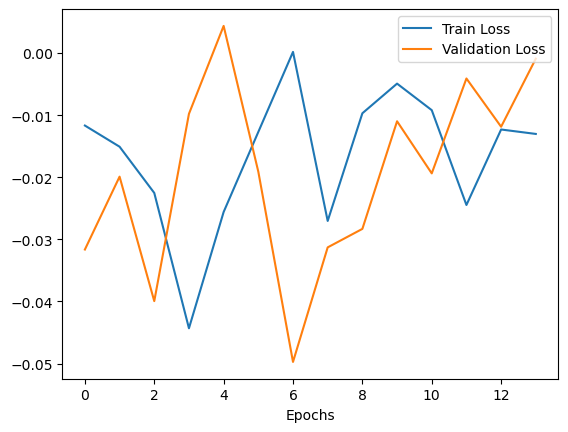

In [1866]:
plot_losses(train_losses, val_losses)

In [ ]:
# Train and Validate model
## Model parameters
dim_val = 256 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 2 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
input_size = 78 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 20 # length of input given to decoder. Can have any integer value.
enc_seq_len = 20 # length of input given to encoder. Can have any integer value.
output_sequence_length = 1 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

batch_size = 32

model = Transformer_port(
    batch_first=True,
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads)

loss_function = sharpe_loss
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# loop through different time periods
df_predictions = pd.DataFrame()
test_losses = []
benchmark_returns = []
benchmark_sharpe = []
portfolio_returns = []
portfolio_sharpe = []
for i in range(4,9):
    t0 = dt.now()
    df_val, df_train, df_test = train_val_test(data, lookback, train_years=i+1) 

    train_dataset = TS_Dataset_attn(df_train, lookback=lookback)
    val_dataset = TS_Dataset_attn(df_val, lookback=lookback)
    test_dataset = TS_Dataset_attn(df_test, lookback=lookback)

    # Should I shuffle data for models with memory? RNN order matters
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=False)

    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False)

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)


    train_losses = []
    val_losses = []
    for epoch in range(100):
        print(f"Epoch {epoch}\n---------")
        train_loss = train_model_attn(train_loader, model, loss_function, optimizer=optimizer)
        train_losses.append(train_loss)
        val_loss = test_model_attn(val_loader, model, loss_function)
        val_losses.append(val_loss)
    
        if early_stop(val_losses, tolerance=100):
            print('Early Stop Triggered')
            break
    
        print('Train loss: {}'.format(train_loss))
        print('Validation loss: {}'.format(val_loss))
        print()
    test_loss = test_model_attn(test_loader, model, loss_function)
    test_losses.append(test_loss)
    
    df_int = get_pred_df_sharpe_attn(df_train,
                                df_test,
                                model=model,
                                batch_size=batch_size,
                                lookback=lookback,
                                tickers=tickers,
                                test_only=True)
    df_predictions = pd.concat([df_predictions, df_int]).sort_index(ascending=True)
    
    bm_r = total_return(df_int['return_benchmark'])
    bm_s = sharpe_ratio(df_int['return_benchmark'])
    p_r = total_return(df_int['return_portfolio'])
    p_s = sharpe_ratio(df_int['return_portfolio'])
    
    benchmark_returns.append(bm_r)
    benchmark_sharpe.append(bm_s)
    portfolio_returns.append(p_r)
    portfolio_sharpe.append(p_s)
    
    t1 = dt.now()
    T = (t1 - t0).total_seconds()
    print()
    print('Test loss: {} Portfolio return: {}, Portfolio Sharpe: {}'.format(test_loss, p_r, p_s))
    print('Benchmark return: {}, Benchmark Sharpe: {}'.format(bm_r, bm_s))
    
    print('Total seconds to train:  {}'.format(T))

Epoch 0
---------
Train loss: 0.01683867949177511
Validation loss: -0.036533910781145096

Epoch 1
---------
Train loss: -0.13899879024829714
Validation loss: -0.03000578936189413

Epoch 2
---------
Train loss: -0.1910505100619048
Validation loss: -0.14799159980611876

Epoch 3
---------
Train loss: -0.2861383525421843
Validation loss: -0.04558201227337122

Epoch 4
---------
Train loss: -0.3127506424847525
Validation loss: -0.10976086370646954

Epoch 5
---------
Train loss: -0.3036656121723354
Validation loss: -0.09101155330426991

Epoch 6
---------
Train loss: -0.42319296547211704
Validation loss: -0.09982783440500498

Epoch 7
---------
Train loss: -0.41262211626453793
Validation loss: -0.10506203463592101

Epoch 8
---------
Train loss: -0.4241649214643985
Validation loss: -0.12242060236167163

Epoch 9
---------
Train loss: -0.41936964336782695
Validation loss: -0.11547047598287463

Epoch 10
---------
Train loss: -0.4602926111780107
Validation loss: -0.03120465623214841

Epoch 11
------

Train loss: -1.4791580744087696
Validation loss: -0.08963091007899493

Epoch 93
---------
Train loss: -1.6122696332633495
Validation loss: -0.055410118502550176

Epoch 94
---------
Train loss: -1.8096124172210692
Validation loss: -0.017418723786249757

Epoch 95
---------
Train loss: -1.9364681258797645
Validation loss: -4.9042049795389175e-05

Epoch 96
---------
Train loss: -1.5462843626737595
Validation loss: -0.04502227862394648

Epoch 97
---------
Train loss: -1.8343536049127578
Validation loss: -0.05432416405528784

Epoch 98
---------
Train loss: -1.7642071552574634
Validation loss: -0.10245815059170127

Epoch 99
---------
Train loss: -1.8807978741824627
Validation loss: -0.05176996858790517


Test loss: -0.04928422595063845 Portfolio return: -0.09025285914847825, Portfolio Sharpe: -0.9521481382733527
Benchmark return: -0.09441694602287076, Benchmark Sharpe: -0.9024224082537796
Total seconds to train:  1128.742161
Epoch 0
---------
Train loss: -1.264196308213286
Validation loss: 0.

Train loss: -2.6690385000159345
Validation loss: -0.025900731678120792

Epoch 82
---------
Train loss: -2.6097734750558934
Validation loss: 0.007209425908513367

Epoch 83
---------
Train loss: -2.7380791567265987
Validation loss: -0.037331046478357166

Epoch 84
---------
Train loss: -2.7355931817243495
Validation loss: -0.04748111078515649

Epoch 85
---------
Train loss: -2.6869082947572074
Validation loss: -0.062424263916909695

Epoch 86
---------
Train loss: -2.842358462512493
Validation loss: -0.05121378554031253

Epoch 87
---------
Train loss: -3.013395417481661
Validation loss: -0.07970391400158405

Epoch 88
---------
Train loss: -2.8480113881329694
Validation loss: -0.06383424904197454

Epoch 89
---------
Train loss: -3.141000331689914
Validation loss: -0.07871118956245482

Epoch 90
---------
Train loss: -2.6120997089892626
Validation loss: -0.0465912080835551

Epoch 91
---------
Train loss: -2.667808827633659
Validation loss: -0.03557448834180832

Epoch 92
---------
Train loss: 

Train loss: -3.3182817469943653
Validation loss: -0.037778474390506744

Epoch 71
---------
Train loss: -3.3399289819327267
Validation loss: -0.04801350925117731

Epoch 72
---------
Train loss: -3.3745545208454133
Validation loss: -0.005678910296410322

Epoch 73
---------
Train loss: -3.5654535391113975
Validation loss: -0.03540829964913428

Epoch 74
---------
Train loss: -3.49150587645444
Validation loss: -0.03234249306842685

Epoch 75
---------
Train loss: -3.4582809887149115
Validation loss: -0.025373737793415785

Epoch 76
---------
Train loss: -3.4308656551621177
Validation loss: -0.024742237641476095

Epoch 77
---------
Train loss: -3.3728953074325214
Validation loss: 0.008033749123569578

Epoch 78
---------
Train loss: -3.3621494076468728
Validation loss: -0.00899987865705043

Epoch 79
---------
Train loss: -3.4943958553400907
Validation loss: -0.023880447610281408

Epoch 80
---------
Train loss: -3.4919268364256077
Validation loss: -0.01244418416172266

Epoch 81
---------
Train l

Train loss: -3.7765027471478025
Validation loss: 0.036139095434919

Epoch 61
---------
Train loss: -3.930063994157882
Validation loss: 0.03448026953265071

Epoch 62
---------
Train loss: -3.9079133565463717
Validation loss: 0.0012288015568628907

Epoch 63
---------
Train loss: -3.9024535812555796
Validation loss: -0.0030365323182195425

Epoch 64
---------
Train loss: -3.6342446955423506
Validation loss: 0.01576902566011995

Epoch 65
---------
Train loss: -4.111417512572001
Validation loss: 0.02002718730363995

Epoch 66
---------
Train loss: -3.8754456182793966
Validation loss: 0.003527852793922648

Epoch 67
---------
Train loss: -4.074041389047154
Validation loss: 0.03736773389391601

Epoch 68
---------
Train loss: -3.8059361248262347
Validation loss: 0.06258873362094164

Epoch 69
---------
Train loss: -4.036231999241171
Validation loss: 0.021594689693301916

Epoch 70
---------
Train loss: -3.883930816536858
Validation loss: -0.003947693854570389

Epoch 71
---------
Train loss: -3.8628

In [1878]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
predict_attn(train_eval_loader, model).shape

torch.Size([754, 1, 13])

In [1670]:
x = dt.now()
y = dt.now()
print((y-x).total_seconds())

5.6e-05


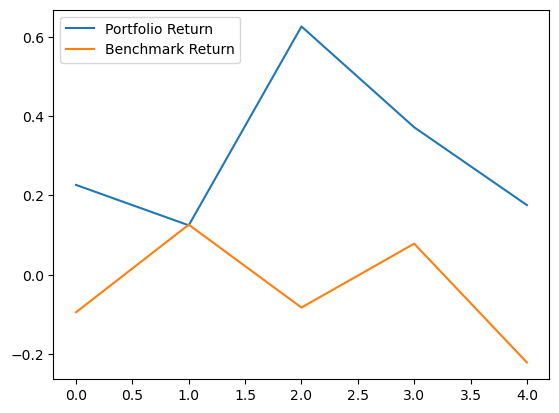

In [1732]:
plot_returns(portfolio_returns, benchmark_returns)
#plot_returns(portfolio_sharpe, benchmark_sharpe, returns=False)

In [1675]:
test = get_pred_df_sharpe(df_train,
                          df_test,
                          model=model,
                          batch_size=batch_size,
                          lookback=lookback,
                          tickers=tickers,
                          test_only=True)
test.iloc[:, 13:-7].abs().sum(axis=1) # check sum of each column


date
2022-01-03    1.0
2022-01-04    1.0
2022-01-05    1.0
2022-01-06    1.0
2022-01-07    1.0
             ... 
2022-11-03    1.0
2022-11-04    1.0
2022-11-07    1.0
2022-11-08    1.0
2022-11-09    1.0
Length: 216, dtype: float32

In [1739]:
print(total_return(df_predictions['return_benchmark']),
      sharpe_ratio(df_predictions['return_benchmark']),
      total_return(df_predictions['return_portfolio']),
      sharpe_ratio(df_predictions['return_portfolio']),
      total_return(df_predictions['total_portfolio_return']),
      sharpe_ratio(df_predictions['total_portfolio_return']))


-0.04110386456562276 -0.27860653466713636 0.2948391252537641 2.2065942256403877 0.28028503340327693 2.0984947397555547


In [1681]:
df_predictions['USO_port_weight'].min()

-0.2554324269294739